In [1]:
import os
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae

from utils import *
from train_eval import *

import warnings
warnings.filterwarnings('ignore')

# Set seed
np.random.seed(42)


In [2]:
# Set working directory
import wandb
wandb.login()

os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')
model_dir = os.path.join(os.getcwd(), 'models')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [3]:
# See what keys are in the h5py data file
show_keys(dir_path)

{'1_county.h5': ['Los_Angeles', 'New_York', 'Sacramento'], '2_town.h5': ['town_0', 'town_1', 'town_2'], '3_village.h5': ['village_0', 'village_1', 'village_2'], '4_neighborhood.h5': ['germany'], '5_household.h5': ['household_0', 'household_1', 'household_2'], '6_apartment.h5': ['apartment_0', 'apartment_1', 'apartment_2']}
{'1_county.h5': ['60min'], '2_town.h5': ['15min', '60min'], '3_village.h5': ['15min', '60min'], '4_neighborhood.h5': ['15min', '60min'], '5_household.h5': ['15min', '60min'], '6_apartment.h5': ['15min', '5min', '60min']}


In [4]:
# run parameters

tuned_models = [
                'rf',
                'lgbm',
                'xgb',
                'gru',
                'nbeats'
                ]

scale = '3_village'
location = 'village_0'
resolution = 60


config_per_model = {}
for model in tuned_models:
    config, name = get_best_run_config('Wattcast_tuning', '+eval_loss', model, scale)
    config['horizon_in_hours'] = 48 # we did finetuning for 24 hours, but we want to evaluate for 48 hours
    config_per_model[model] = config, name


wandb: Sorting runs by +summary_metrics.eval_loss
wandb: Sorting runs by +summary_metrics.eval_loss
wandb: Sorting runs by +summary_metrics.eval_loss
wandb: Sorting runs by +summary_metrics.eval_loss
wandb: Sorting runs by +summary_metrics.eval_loss


In [5]:
config_per_model['rf'][0]

{'model': 'rf',
 'boxcox': True,
 'n_lags': 24,
 'holiday': True,
 'n_ahead': 24,
 'weather': True,
 'location': 'village_0',
 'liklihood': None,
 'max_depth': None,
 'eval_stride': 4,
 'n_estimators': 1000,
 'spatial_scale': '3_village',
 'temp_resolution': 60,
 'horizon_in_hours': 48,
 'min_samples_leaf': 1,
 'datetime_encoders': None,
 'lookback_in_hours': 24,
 'min_samples_split': 2,
 'datetime_encodings': 0,
 'longest_ts_val_idx': 0,
 'timesteps_per_hour': 1,
 'longest_ts_test_idx': 0}

In [6]:

# initialize wandb and log config
#os.environ['WANDB_MODE'] = 'offline'
wandb.init(project="WattCast", name=scale + "_" + location + "_" + str(resolution) + "min")



In [7]:
config = Config().from_dict(config_per_model[tuned_models[0]][0])

In [8]:
pipeline, ts_train_piped, ts_val_piped, ts_test_piped, ts_train_weather_piped, ts_val_weather_piped, ts_test_weather_piped, trg_train_inversed, trg_val_inversed, trg_test_inversed = data_pipeline(config)

In [15]:
model_instances = get_model_instances(config_per_model)

models, run_times = train_models(model_instances, 
                        ts_train_piped,
                        ts_train_weather_piped if config.weather else None, 
                        ts_val_piped,
                        ts_val_weather_piped if config.weather else None,
                        )


df_runtimes = pd.DataFrame.from_dict(run_times, orient='index', columns=['runtime']).reset_index()
wandb.log({"runtimes": wandb.Table(dataframe=df_runtimes)})
model_names = list(run_times.keys())
models_dict = {model_name: model for model_name, model in zip(model_names, models)}
save_models_to_disk(config, models_dict)

Training RandomForest


## Evaluation

In [ ]:
test_sets = { # see data_prep.ipynb for the split
            "Winter": (
                        ts_val_piped[config.longest_ts_val_idx], 
                        None if not config.weather else ts_val_weather_piped[config.longest_ts_val_idx],
                        trg_val_inversed
                        ), 
            "Summer": (
                        ts_test_piped[config.longest_ts_test_idx],
                        None if not config.weather else ts_test_weather_piped[config.longest_ts_test_idx],
                        trg_test_inversed
                        )
                        }



In [ ]:

n_aheads = [i * config.timesteps_per_hour for i in [1, 4, 8, 24, 48]] # horizon in hours
list_metrics = [rmse, r2_score, mae, smape, mape] # evaluation metrics

dict_result_n_ahead = {}
for n_ahead in n_aheads:
    print(f"Forecasting {n_ahead//config.timesteps_per_hour} hours ahead")
    eval_stride = int(np.sqrt(n_ahead))
    dict_result_season = {}
    for season, (ts, ts_cov, gt) in test_sets.items():
        print(f"Testing on {season} data")
        # Generating Historical Forecasts for each model
        ts_predictions_per_model = {}
        historics_per_model = {}
        for model_name, model in models_dict.items():
            print(f"Generating historical forecasts with {model_name}")
            historics = model.historical_forecasts(ts, 
                                                future_covariates= ts_cov if model.supports_future_covariates else None,
                                                start=ts.get_index_at_point(config.n_lags),
                                                verbose=True,
                                                stride= eval_stride, 
                                                forecast_horizon=n_ahead, 
                                                retrain=False, 
                                                last_points_only=False,
                                                )
            
            
            historics_inverted = [pipeline.inverse_transform(historic) for historic in historics][1:] # the first historic is partly nan, so we skip it
            historics_per_model[model_name] = historics_inverted # storing the forecasts in batches of the forecasting horizon, for plot 2
            ts_predictions = ts_list_concat(historics_inverted, eval_stride) # concatenating the batches into a single time series for plot 1, this makes sure side-by-side comparison is in n_ahead interval
            ts_predictions_per_model[model_name] = ts_predictions
        

        ts_predictions_per_model['24-Hour Persistence'] = gt.shift(config.timesteps_per_hour*24) # adding the 24-hour persistence model as a benchmark
        
        dict_result_season[season] = historics_per_model, ts_predictions_per_model, gt

    dict_result_n_ahead[n_ahead] = dict_result_season

model_names.append('24-Hour Persistence') # add persistence model

## Plots & Analysis

### Plot 1: Side-by-side comparison of the models

In [ ]:
df_cov_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_cov')
df_cov_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_cov')
df_cov_test = pd.read_hdf(os.path.join(dir_path,f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_cov')
temp_data = {'Summer': df_cov_test.iloc[:,0], 'Winter': df_cov_val.iloc[:,0]}




for n_ahead, dict_result_season in dict_result_n_ahead.items():

    for season, (_, preds_per_model, gt) in dict_result_season.items():
        fig = go.Figure()

        # Add the ground truth data to the left axis
        fig.add_trace(go.Scatter(x=gt.pd_series().index, y=gt.pd_series().values, name="Ground Truth", yaxis="y1"))

        for model_name in model_names:
            preds = preds_per_model[model_name]
            fig.add_trace(go.Scatter(x=preds.pd_series().index, y=preds.pd_series().values, name=model_name, yaxis="y1"))

        # Add the df_cov_test data to the right axis
        
        series_weather = temp_data[season]
        fig.add_trace(go.Scatter(
        x=series_weather.index,
        y=series_weather.values,
        name="temperature",
        yaxis="y2",
        line=dict(dash="dot")  # Set the line style to dotted
    ))

        fig.update_layout(
            title=f"{season} - Horizon: {n_ahead// config.timesteps_per_hour} Hours",
            xaxis=dict(title="Time"),
            yaxis=dict(title=f"Power [{ts_train_piped[0].components[0][-2:]}]", side="left"),
            yaxis2=dict(title="Temperature [°C]", overlaying="y", side="right"),
        )

        fig.show()
        wandb.log({f"{season} - Side-by-side comparison of predictions and the ground truth": fig})


### Error Metrics Table

In [ ]:
metrics_tables = []

for n_ahead, dict_result_season in dict_result_n_ahead.items():
    for season, (_, preds_per_model, gt) in dict_result_season.items():
        df_metrics = get_error_metric_table(list_metrics, preds_per_model, gt)
        rmse_persistence = df_metrics.loc[df_metrics.index == '24-Hour Persistence', 'rmse'].values[0]
        df_metrics.drop(labels= [model_names[-1]], axis = 0, inplace=True)
        df_metrics.reset_index(inplace=True)
        df_metrics['season'] = season
        df_metrics.set_index('season', inplace=True)
        df_metrics.reset_index(inplace=True)
        df_metrics['horizon_in_hours'] = n_ahead//config.timesteps_per_hour
        df_metrics.set_index('horizon_in_hours', inplace=True)
        df_metrics.reset_index(inplace=True)
        df_metrics['rmse_skill_score'] = 1 - df_metrics['rmse'] / rmse_persistence
        metrics_tables.append(df_metrics)

df_metrics = pd.concat(metrics_tables, axis=0, ignore_index=True).sort_values(by=['season', 'horizon_in_hours'])

wandb.log({f"Error metrics for {config.spatial_scale} in {config.location}": wandb.Table(dataframe=df_metrics)})

model_names.pop(-1)

'24-Hour Persistence'

### Plot 2: Error Metric Trajectories

In [ ]:

n_ahead, dict_result_season = list(dict_result_n_ahead.items())[-1]

dict_result_season = dict_result_n_ahead[n_ahead]
df_smapes_per_season = {}
df_nrmse_per_season = {}

for season, (historics_per_model, _, gt) in dict_result_season.items():
    df_smapes_per_model = []
    df_rmse_per_model = []
    for model_name, historics in historics_per_model.items():
        df_list = get_df_compares_list(historics, gt)
        diffs = get_df_diffs(df_list)
        df_smapes = abs(diffs).mean(axis =1) 
        df_smapes.columns = [model_name]
        df_rmse = np.square(diffs).mean(axis =1) 
        df_rmse.columns = [model_name]

        df_smapes_per_model.append(df_smapes)
        df_rmse_per_model.append(df_rmse)

    df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1).ewm(alpha=0.1).mean()
    df_smapes_per_model.columns = model_names
    df_nrmse_per_model = pd.concat(df_rmse_per_model, axis=1).ewm(alpha=0.1).mean()
    df_nrmse_per_model.columns = model_names
    df_smapes_per_season[season] = df_smapes_per_model
    df_nrmse_per_season[season] = df_nrmse_per_model

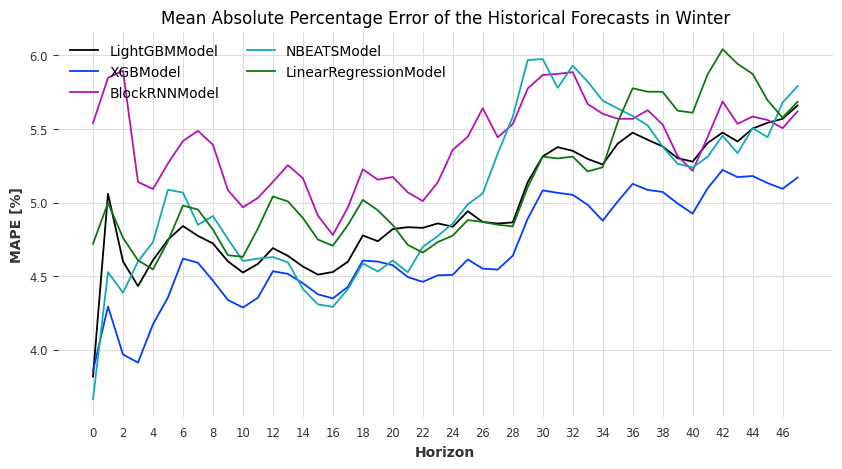

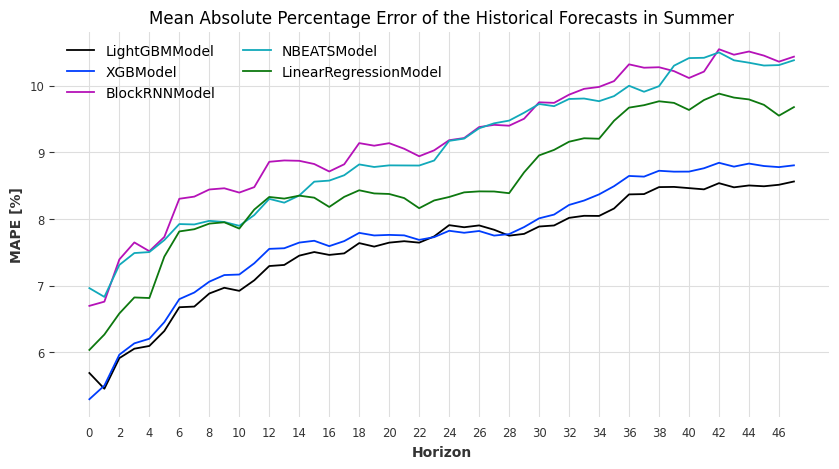

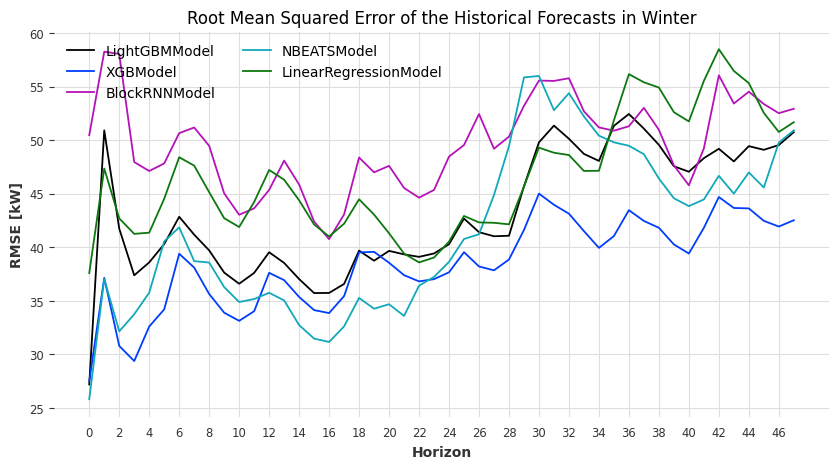

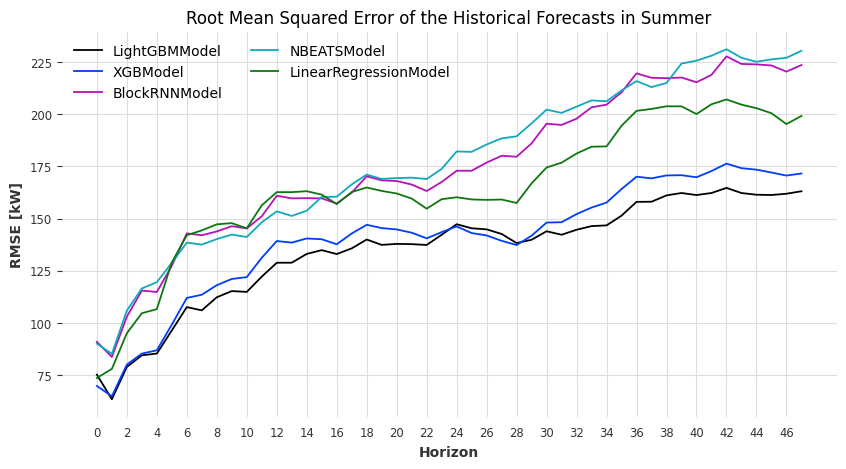

In [ ]:

for season in dict_result_season.keys():
    fig = df_smapes_per_season[season].plot(figsize=(10,5))
    plt.xlabel('Horizon')
    plt.ylabel('MAPE [%]')
    plt.legend(loc = 'upper left', ncol = 2)
    plt.xticks(np.arange(0, n_ahead, 2))
    plt.title(f"Mean Absolute Percentage Error of the Historical Forecasts in {season}")
    wandb.log({f"MAPE of the Historical Forecasts in {season}": wandb.Image(fig)})
    
for season in dict_result_season.keys():
    fig = df_nrmse_per_season[season].plot(figsize=(10,5))
    plt.xlabel('Horizon')
    plt.ylabel(f'RMSE [{ts_train_piped[0].components[0][-2:]}]')
    plt.xticks(np.arange(0, n_ahead, 2))
    plt.legend(loc = 'upper left', ncol = 2)
    plt.title(f"Root Mean Squared Error of the Historical Forecasts in {season}")
    wandb.log({f"RMSE of the Historical Forecasts in {season}": wandb.Image(fig)})

### Plot 3: Error distribution

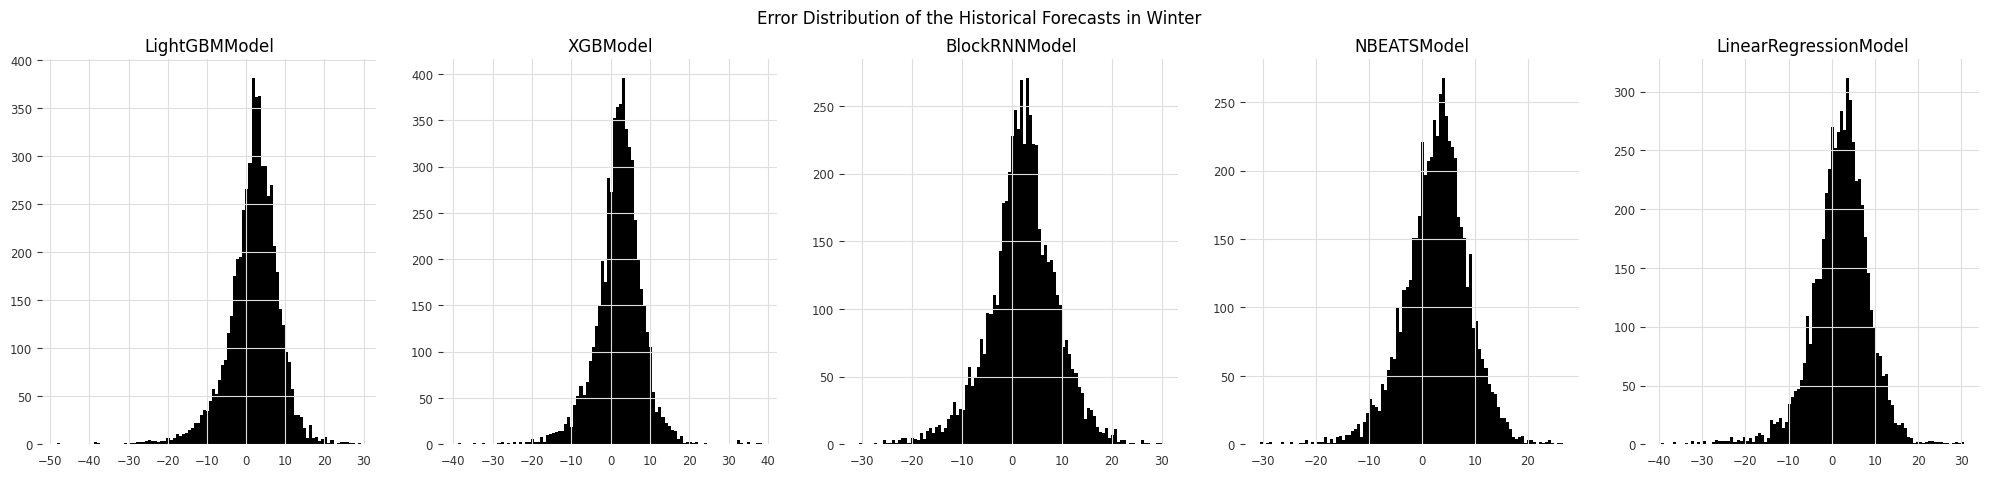

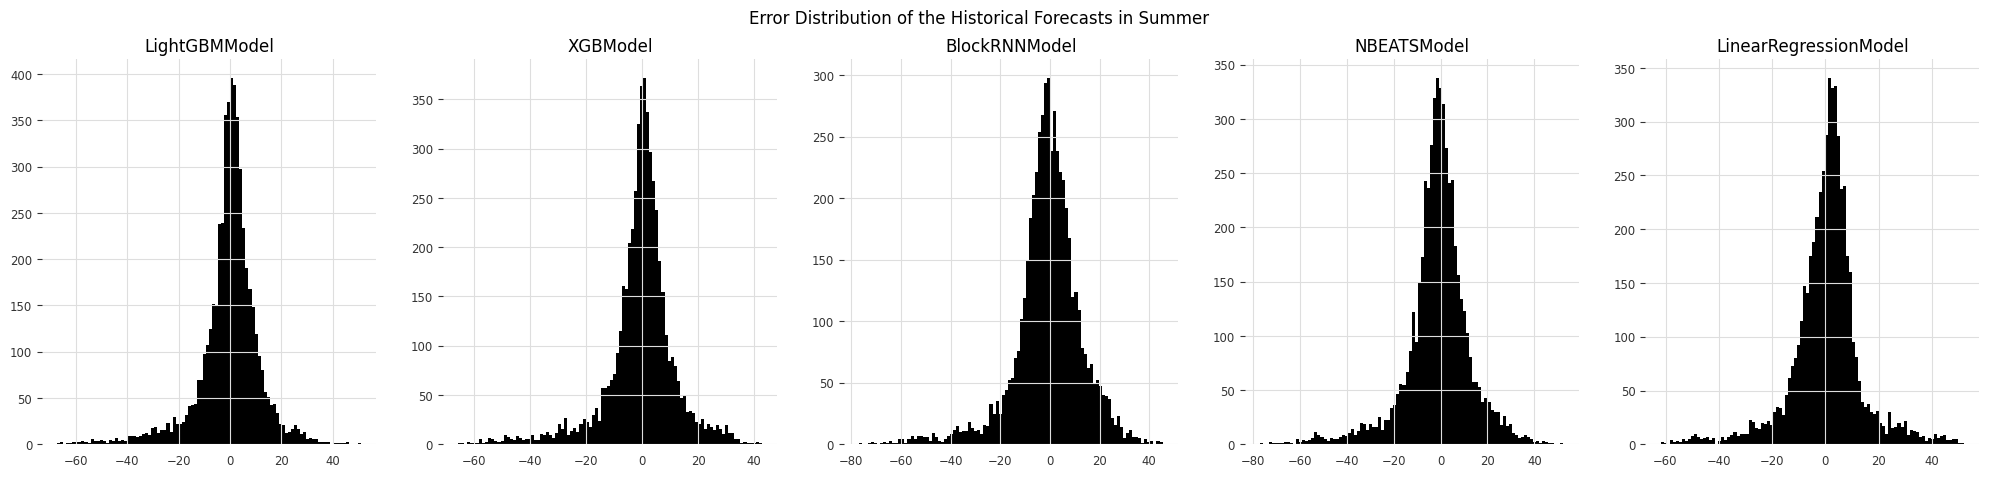

In [ ]:
for season, (historics_per_model, _, gt) in dict_result_season.items():
    df_smapes_per_model = []
    df_nrmse_per_model = []
    fig, ax = plt.subplots(ncols=len(model_names), figsize=(5*len(model_names),5))
    fig.suptitle(f"Error Distribution of the Historical Forecasts in {season}")
    for i, (model_name, historics) in enumerate(historics_per_model.items()):
        df_list = get_df_compares_list(historics, gt)
        diffs = get_df_diffs(df_list)
        diffs_flat = pd.Series(diffs.values.reshape(-1,))
        ax[i].hist(diffs_flat, bins=100)
        ax[i].set_title(model_name)
    
    wandb.log({f"Error Distribution of the Historical Forecasts in {season}": wandb.Image(fig)})
    plt.show()



### Plot 4: Per Day

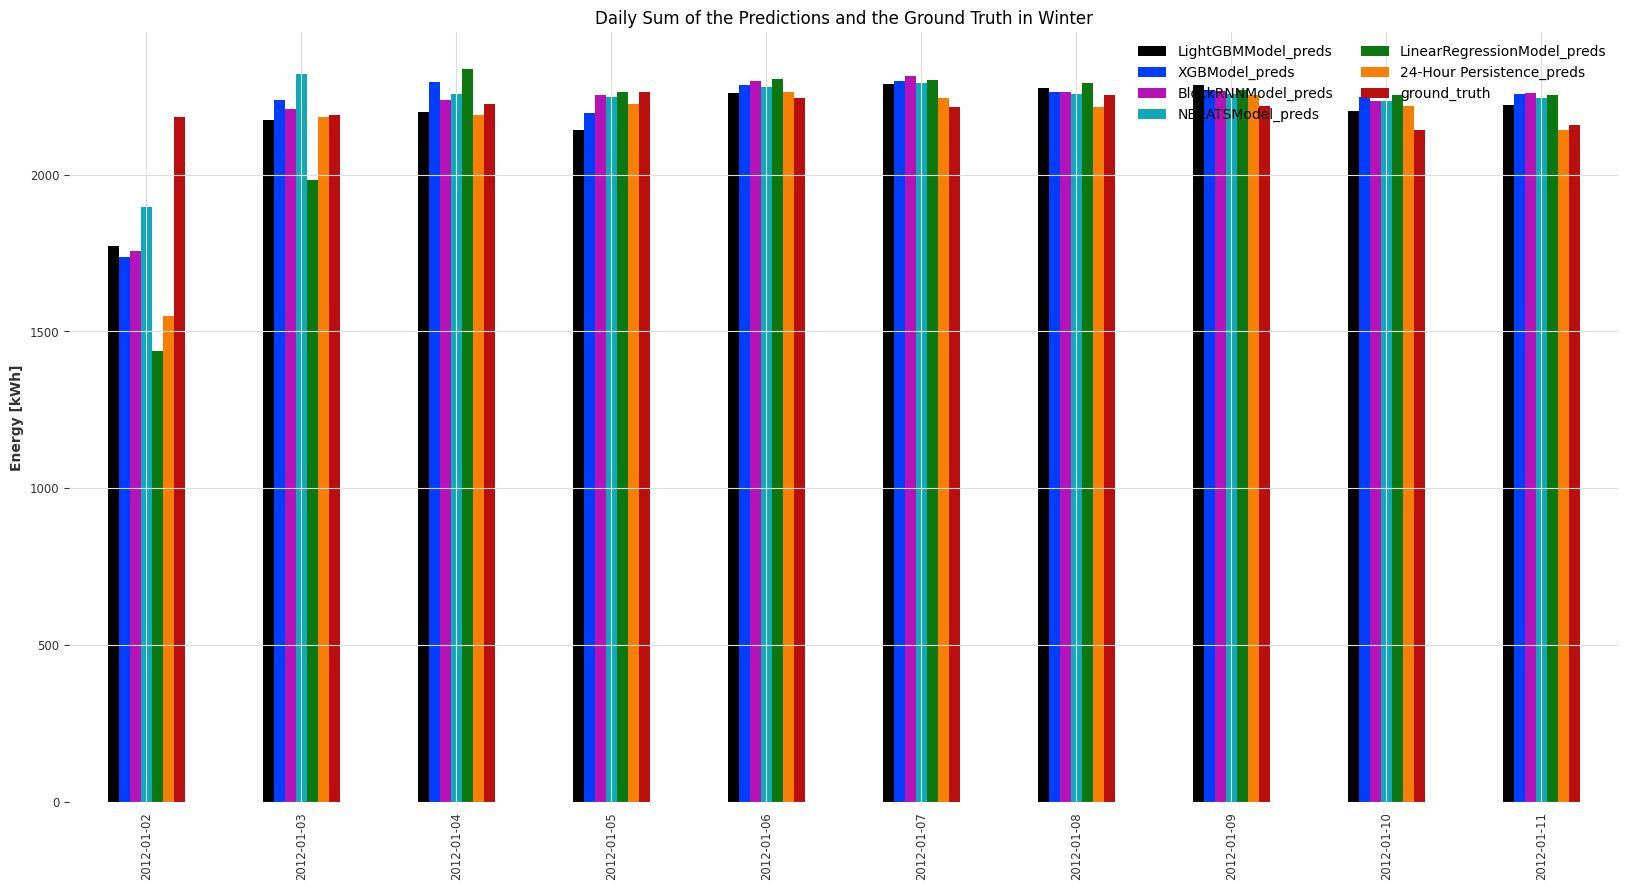

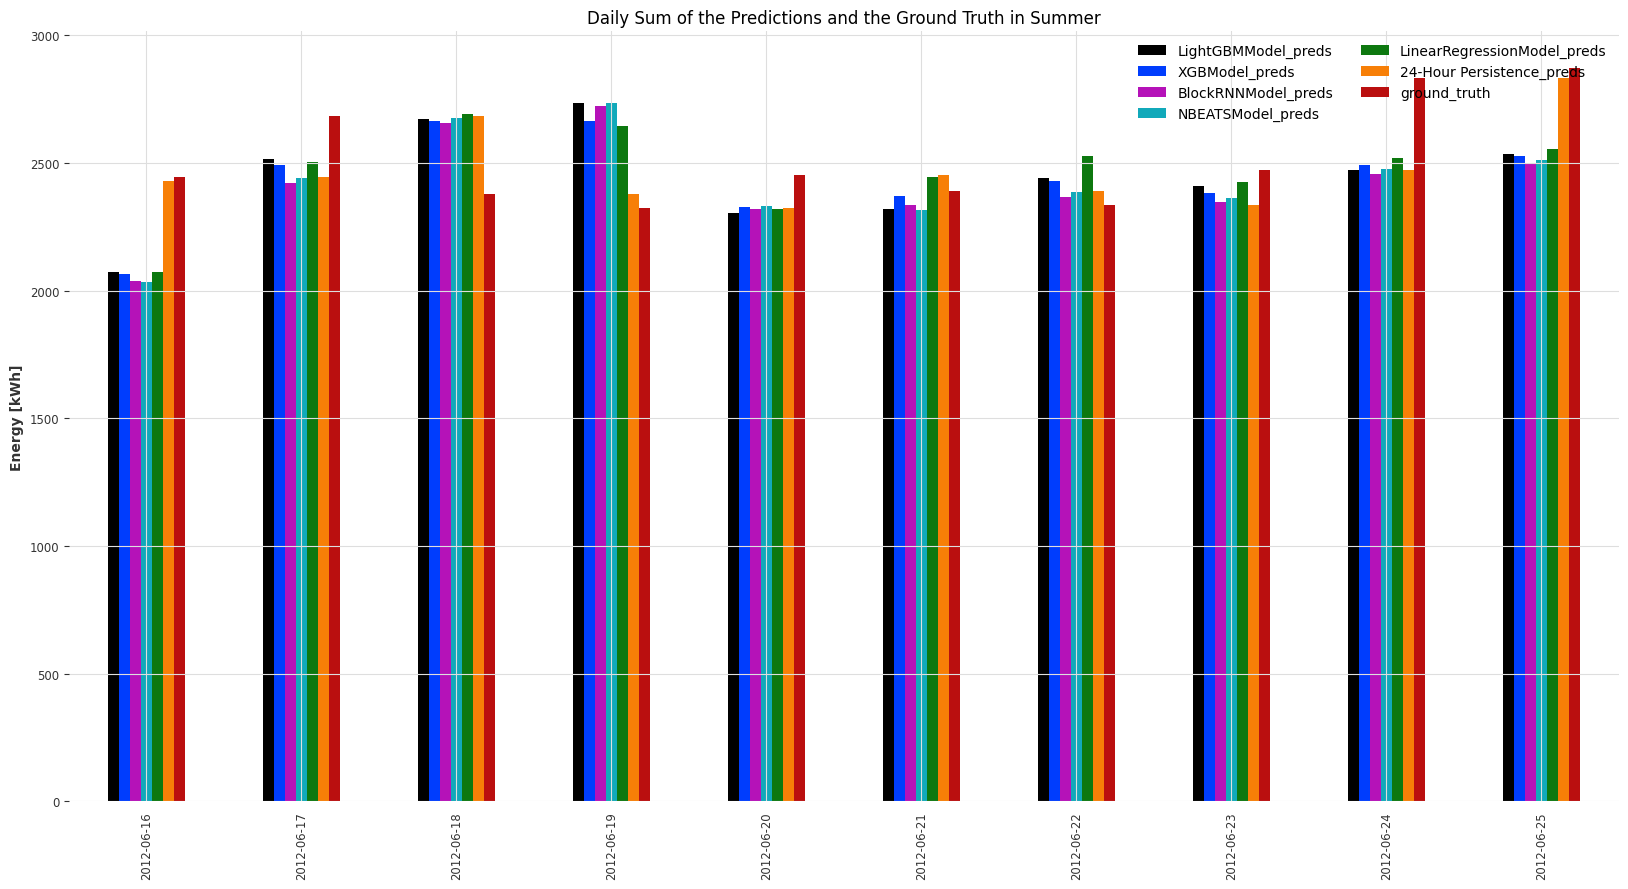

In [ ]:
for season, (_, preds_per_model, gt) in dict_result_season.items():
    dfs_daily_sums = []
    for model_name, preds in preds_per_model.items():
        df_preds = preds.pd_series().to_frame(model_name + "_preds")
        z = df_preds.groupby(df_preds.index.date).sum()
        dfs_daily_sums.append(z)

    df_gt = gt.pd_series().to_frame("ground_truth") 
    z = df_gt.groupby(df_gt.index.date).sum() / config.timesteps_per_hour
    dfs_daily_sums.append(z)
    df_compare = pd.concat(dfs_daily_sums, axis=1).dropna()
    fig = df_compare[:10].plot(kind='bar', figsize=(20,10))
    plt.legend(loc = 'upper right', ncol = 2)
    plt.ylabel(f'Energy [{ts_train_piped[0].components[0][-2:]}h]')
    plt.title(f"Daily Sum of the Predictions and the Ground Truth in {season}")
    wandb.log({f"Daily Sum of the Predictions and the Ground Truth in {season}": wandb.Image(fig)})
wandb.finish()